#  Fundamentos das LLMs


In [56]:
from transformers import BertForTokenClassification, DistilBertTokenizerFast, pipeline
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm

In [57]:
articles = pd.read_csv("articles.csv")

In [58]:
inicio = '2015-01-01'
fim = '2015-03-31'

articles_mercado = articles[(articles['category']=='mercado') & (articles['date'] >= inicio) & (articles['date'] <= fim)]
text_list = articles_mercado.text.tolist()
texts = [ text for text in text_list if pd.notna(text)]


In [77]:
filtered_df = articles_mercado[articles_mercado['text'].str.contains("setembro", case=False, na=False)]


In [81]:
filtered_df

,title,text,date,category,subcategory,link
99055,Prioridade ao pós-pago reduz número de linhas ...,"O mercado de telefonia celular perdeu 2,09 mil...",2015-03-12,mercado,NaN,http://www1.folha.uol.com.br/mercado/2015/12/1...
99064,Reportagem da Folha sobre investidor mais jove...,"A reportagem da Folha ""Príncipe da Bolsa"", de ...",2015-03-12,mercado,NaN,http://www1.folha.uol.com.br/mercado/2015/12/1...
99076,Petrobras anuncia 2º reajuste no preço do gás ...,A Petrobras comunicou ao mercado novo reajuste...,2015-03-12,mercado,NaN,http://www1.folha.uol.com.br/mercado/2015/12/1...
99111,Ex-ministro da Fazenda diz que incerteza polít...,A crise política no Brasil está aumentando as ...,2015-03-12,mercado,NaN,http://www1.folha.uol.com.br/mercado/2015/12/1...
99123,Medidas do Banco Central Europeu decepcionam m...,As promessas do BCE (Banco Central Europeu) pa...,2015-03-12,mercado,NaN,http://www1.folha.uol.com.br/mercado/2015/12/1...
...,...,...,...,...,...,...
164402,"Após subir até 1,7%, Bolsa perde força com EUA...","Depois de ter subido até 1,66% ao longo do dia...",2015-01-13,mercado,NaN,http://www1.folha.uol.com.br/mercado/2015/01/1...
164477,Bolsa sobe com foco no setor elétrico e ajudad...,A Bolsa brasileira opera em alta nesta terça-f...,2015-01-13,mercado,NaN,http://www1.folha.uol.com.br/mercado/2015/01/1...
166558,OAS vai reduzir despesas e pode vender ativos ...,Um dia após falhar com o compromisso de pagar ...,2015-03-01,mercado,NaN,http://www1.folha.uol.com.br/mercado/2015/01/1...
166849,Brasil deve perder para a Índia o 7º lugar ent...,O fraco crescimento do Brasil deverá fazer o p...,2015-02-01,mercado,NaN,http://www1.folha.uol.com.br/mercado/2015/01/1...


In [59]:
len(texts)

2111

In [60]:
texts

['O mercado de telefonia celular perdeu 2,09 milhões de linhas em outubro, diante de nova diminuição no número de acessos pré-pagos, de acordo com dados da Anatel (Agência Nacional de Telecomunicações).  A base de telefonia móvel do país no fim de outubro era de 273,8 milhões de acessos, dos quais 201,3 milhões correspondiam a linhas pré-pagas, e 72,5 milhões, a pós-pagas.  Um ano antes, o Brasil tinha pouco mais de 279 milhões de acessos celulares, dos quais 213 milhões eram conexões pré-pagas, e 66 milhões, pós.  O desempenho de outubro marcou o quinto mês seguido de queda na base da telefonia móvel, diante de estratégia das operadoras de priorizar segmento mais rentável de pós-pagos e com tendência dos usuários de reduzir o número de chips em uso.    A operadora que viu a maior redução da base em setembro foi a Claro, do grupo América Móvil, com queda de 1,3 milhão de acessos, para 69 milhões.  Em seguida, a TIM teve recuo de mais de 660 mil linhas, para 71,9 milhões em outubro. Oi 

In [61]:
model = BertForTokenClassification.from_pretrained('monilouise/ner_pt_br')
tokenizer = DistilBertTokenizerFast.from_pretrained('neuralmind/bert-base-portuguese-cased'
                                                    , model_max_length=512
                                                    , do_lower_case=False
                                                    )
nlp = pipeline('ner', model=model, tokenizer=tokenizer,  aggregation_strategy="max")


Some weights of the model checkpoint at monilouise/ner_pt_br were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'DistilBertTokenizer'.
The tokenizer class you load from this check

In [62]:
def extract_entities(text, max_tokens=512):
    entities = []
    words = text.split()
    blocks = []
    for word in words:
        blocks.append(word)
        text_truncated = " ".join(blocks)
        tokens = tokenizer(text_truncated, return_tensors="pt", truncation=False)
        if tokens.input_ids.shape[1] >= max_tokens:
            blocks.pop()
            text_truncated = " ".join(blocks)
            entities.extend(nlp(text_truncated))
            blocks = [word]
    entities.extend(nlp(text_truncated))
    return entities

In [63]:
all_entities = []
for text in tqdm(texts):
    all_entities.extend(extract_entities(text))

100%|██████████| 2111/2111 [07:37<00:00,  4.62it/s]


In [64]:
all_entities

[{'entity_group': 'PUB',
  'score': np.float32(0.97653186),
  'word': 'Anatel',
  'start': 154,
  'end': 160},
 {'entity_group': 'PUB',
  'score': np.float32(0.98799914),
  'word': 'Agência Nacional de',
  'start': 162,
  'end': 181},
 {'entity_group': 'PUB',
  'score': np.float32(0.9862024),
  'word': 'Telecomunicações',
  'start': 182,
  'end': 198},
 {'entity_group': 'LOC',
  'score': np.float32(0.9301639),
  'word': 'Brasil',
  'start': 389,
  'end': 395},
 {'entity_group': 'ORG',
  'score': np.float32(0.9620528),
  'word': 'Claro',
  'start': 818,
  'end': 823},
 {'entity_group': 'ORG',
  'score': np.float32(0.6072517),
  'word': 'grupo',
  'start': 828,
  'end': 833},
 {'entity_group': 'ORG',
  'score': np.float32(0.72038513),
  'word': 'América',
  'start': 834,
  'end': 841},
 {'entity_group': 'ORG',
  'score': np.float32(0.9727649),
  'word': 'Móvil',
  'start': 842,
  'end': 847},
 {'entity_group': 'ORG',
  'score': np.float32(0.96608555),
  'word': 'TIM',
  'start': 916,
  '

In [69]:
results = [entity['word'] for entity in all_entities if entity['entity_group'] in ["ORG"] and len(entity['word']) > 1 ]

In [75]:
len(results)

12979

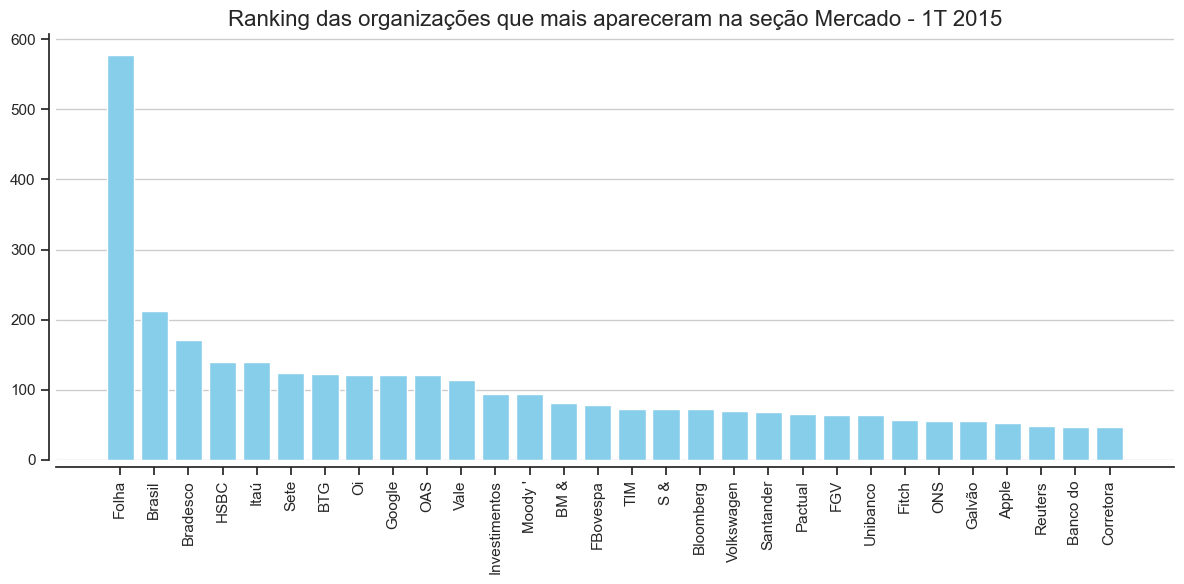

In [74]:
sns.set_theme(style="ticks")

tops = dict(Counter(results).most_common(30))

# Gráfico
plt.figure(figsize=(12, 6))
ax = plt.bar(tops.keys(), tops.values(), color='skyblue')
plt.title("Ranking das organizações que mais apareceram na seção Mercado - 1T 2015", fontsize=16)
sns.despine(offset=5)
plt.grid(":", axis='y')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [68]:
import os

# Caminho do diretório
folder_path = "capitulo_3"

# Percorre todos os arquivos no diretório
for filename in os.listdir(folder_path):
    # Checa se o nome do arquivo contém espaços
    if " " in filename:
        old_path = os.path.join(folder_path, filename)
        new_filename = filename.replace(" ", "-")
        new_path = os.path.join(folder_path, new_filename)

        # Renomeia o arquivo
        os.rename(old_path, new_path)
        print(f"Renomeado: {filename} → {new_filename}")